In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nest_asyncio

nest_asyncio.apply()

In [3]:
import numpy as np
import pylab as pl
from genparse.util import lark_guide, set_seed, load_model_by_name
from genparse.proposal import TokenProposal, CharacterProposal
from genparse.steer import Sampler
from arsenal import timers, timeit, iterview

WARNING 07-19 12:43:27 _custom_ops.py:14] Failed to import from vllm._C with ImportError('libcuda.so.1: cannot open shared object file: No such file or directory')


In [4]:
guide = lark_guide(
    r"""
    start: /[ ]*Tim(othy)?[ ](Fabbri[ ])?Vieira\./
    """
)

llm = load_model_by_name('gpt2')
prompt = llm.encode_prompt('Hello my name is')

guide.V |= {w for word in llm.V for w in word}

In [5]:
tok = TokenProposal(llm=llm, guide=guide, K=None)

In [6]:
char = CharacterProposal(llm=llm, guide=guide)

In [7]:
sampler = Sampler(llm=llm, guide=guide)

In [8]:
opts = dict(
    n_particles=100,
    method='importance-sampling',
    max_tokens=100,
    prompt=prompt,
    seed=8675309,
)

In [9]:
T = timers()

In [10]:
with T['token']:
    tok_posterior = sampler.run_inference(proposal=tok, **opts)

/home/timv/projects/genparse/genparse/steer.py:270: RuntimeWarning: divide by zero encountered in log
  if particles.ess < np.log(ess_threshold) * particles.size:


In [11]:
with T['character']:
    char_posterior = sampler.run_inference(proposal=char, **opts)

/home/timv/projects/genparse/genparse/steer.py:270: RuntimeWarning: divide by zero encountered in log
  if particles.ess < np.log(ess_threshold) * particles.size:


In [12]:
T.compare()

character is 1.1414x faster than token (p=1.00000, median: token: 29.5555, character: 25.8937)


In [13]:
char_posterior = char_posterior.finalize(guide.eos)

In [14]:
tok_posterior = tok_posterior.finalize(guide.eos)

In [15]:
tok_W = np.mean([np.exp(p.weight) for p in tok_posterior.particles])

In [16]:
char_W = np.mean([np.exp(p.weight) for p in char_posterior.particles])

In [17]:
# np.exp(tok_posterior.log_ml - char_posterior.log_ml), tok_posterior.log_ml, char_posterior.log_ml

The variance of the weights

In [18]:
np.std(np.exp(tok_posterior.log_weights)) / np.std(np.exp(char_posterior.log_weights))

0.11758935959704561

In [19]:
char_posterior

key,value
Tim Vieira.▪,0.7268916168040848
Timothy Vieira.▪,0.19221204277721665
Tim Vieira.▪,0.08089628965972455
Tim Fabbri Vieira.▪,5.075874152012345e-08
Timothy Fabbri Vieira.▪,2.3236552914547823e-13


In [20]:
tok_posterior

key,value
Tim Vieira.▪,0.9999977478288168
Timothy Vieira.▪,2.252168557823613e-06
Timothy Fabbri Vieira.▪,1.4360158318861312e-12
Tim Fabbri Vieira.▪,1.1893443531848075e-12


In [21]:
char_posterior.show()

-26.70:	[Tim| V|ie|ira|.|▪]
-29.13:	[ Timothy| V|ie|ira|.|▪]
-29.13:	[ Timothy| V|ie|ira|.|▪]
-29.13:	[ Timothy| V|ie|ira|.|▪]
-30.50:	[ Tim| V|ie|ira|.|▪]
-30.50:	[ Tim| V|ie|ira|.|▪]
-30.50:	[ Tim| V|ie|ira|.|▪]
-30.50:	[ Tim| V|ie|ira|.|▪]
-30.50:	[ Tim| V|ie|ira|.|▪]
-37.81:	[ Tim| V|ie|ir|a|.|▪]
-39.59:	[ Tim| |V|ie|ira|.|▪]
-39.80:	[ T|im| V|ie|ira|.|▪]
-39.80:	[ T|im| V|ie|ira|.|▪]
-41.24:	[ Tim| V|ie|i|ra|.|▪]
-43.17:	[ Tim| F|abb|ri| V|ie|ira|.|▪]
-50.79:	[ T|im| V|ie|i|ra|.|▪]
-53.08:	[ Tim| Fab|b|ri| V|ie|ira|.|▪]
-53.90:	[ Ti|m|oth|y| V|ie|ira|.|▪]
-55.05:	[ Tim| F|ab|b|ri| V|ie|ira|.|▪]
-56.85:	[ Timothy| F|abb|ri| |V|ie|ira|.|▪]
-56.85:	[ Timothy| F|abb|ri| |V|ie|ira|.|▪]
-56.85:	[ Timothy| F|abb|ri| |V|ie|ira|.|▪]
-56.85:	[ Timothy| F|abb|ri| |V|ie|ira|.|▪]
-57.36:	[ Tim| F|abb|ri| |V|ie|ira|.|▪]
-57.36:	[ Tim| F|abb|ri| |V|ie|ira|.|▪]
-57.36:	[ Tim| F|abb|ri| |V|ie|ira|.|▪]
-57.36:	[ Tim| F|abb|ri| |V|ie|ira|.|▪]
-57.36:	[ Tim| F|abb|ri| |V|ie|ira|.|▪]
-57.36:	[ Tim| F|

In [22]:
tok_posterior.show()

-29.17:	[ Tim| V|ie|ira|.|▪]
-29.17:	[ Tim| V|ie|ira|.|▪]
-39.91:	[ Tim| V|ie|i|ra|.|▪]
-42.58:	[ T|im|othy| V|ie|ira|.|▪]
-42.58:	[ T|im|othy| V|ie|ira|.|▪]
-42.58:	[ T|im|othy| V|ie|ira|.|▪]
-53.68:	[ Tim|o|th|y| V|ie|ira|.|▪]
-53.68:	[ Tim|o|th|y| V|ie|ira|.|▪]
-53.68:	[ Tim|o|th|y| V|ie|ira|.|▪]
-54.36:	[ Tim|ot|h|y| V|ie|ira|.|▪]
-55.94:	[ Tim| F|abb|ri| |V|ie|ira|.|▪]
-56.06:	[ T|imo|th|y| V|ie|ira|.|▪]
-56.06:	[ T|imo|th|y| V|ie|ira|.|▪]
-56.84:	[ Tim|o|thy| |V|ie|ira|.|▪]
-56.85:	[ Timothy| F|abb|ri| |V|ie|ira|.|▪]
-56.85:	[ Timothy| F|abb|ri| |V|ie|ira|.|▪]
-56.85:	[ Timothy| F|abb|ri| |V|ie|ira|.|▪]
-59.24:	[ T|imo|thy| V|ie|i|ra|.|▪]
-60.32:	[ Tim|o|th|y| V|ie|ir|a|.|▪]
-61.15:	[ Tim|othy| F|abb|ri| |V|ie|ira|.|▪]
-63.33:	[ Tim|o|th|y| |V|ie|ira|.|▪]
-63.89:	[ T|imo|thy| V|i|e|ira|.|▪]
-64.03:	[ T|i|m| V|i|e|ira|.|▪]
-64.15:	[ T|im|othy| V|i|e|ir|a|.|▪]
-65.41:	[ Tim|o|th|y| Vi|e|ir|a|.|▪]
-65.60:	[ T|i|mo|th|y| V|ie|ira|.|▪]
-67.04:	[ Tim|o|t|h|y| V|ie|ira|.|▪]
-67.53:	[ Ti

In [23]:
np.mean(np.exp(char_posterior.log_weights)), np.mean(np.exp(tok_posterior.log_weights))

(3.500536115124748e-14, 4.289079284518432e-15)

In [24]:
np.std(np.exp(char_posterior.log_weights)), np.std(np.exp(tok_posterior.log_weights))

(2.553220360893577e-13, 3.002315471476134e-14)

In [25]:
import seaborn as sns

In [26]:
(
    np.exp(tok_posterior.log_ml - char_posterior.log_ml),
    tok_posterior.log_ml,
    char_posterior.log_ml,
)

(0.12252635434859899, -33.082704303998085, -30.98327516940155)

In [27]:
from arsenal.maths.rvs import Empirical

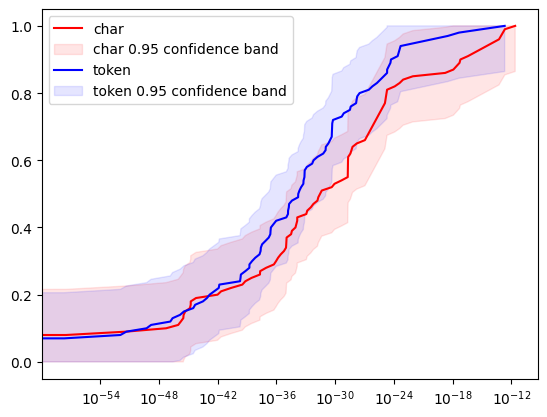

In [28]:
Empirical(np.exp(char_posterior.log_weights)).plot(label='char', color='r')
Empirical(np.exp(tok_posterior.log_weights)).plot(label='token', color='b')
pl.semilogx()
pl.legend();

In [29]:
tok_posterior.ess, char_posterior.ess

(2.0000522628271185, 1.8450357946124256)

In [30]:
from genparse.proposal.crunch import Crunching

In [31]:
cruncher = Crunching(guide=guide, llm=llm)

In [32]:
for x in cruncher.posterior_enumerate(prompt=prompt, beam_width=5, max_generations=1):
    print(x)

Output()

Item(ps=2.193959222251446e-17, xs=(' Tim', 'othy', ' V', 'ie', 'ira', '.', '▪'), ys=('Hello', ' my', ' name', ' 
is', ' Tim', 'othy', ' V', 'ie', 'ira', '.', '<|endoftext|>'))

Item(ps=1.4178393080367892e-21, xs=(' Tim', ' F', 'abb', 'ri', ' V', 'ie', 'ira', '.', '▪'), ys=('Hello', ' my', ' 
name', ' is', ' Tim', ' F', 'abb', 'ri', ' V', 'ie', 'ira', '.', '<|endoftext|>'))

Item(ps=5.838058318966165e-24, xs=(' Tim', 'othy', ' F', 'abb', 'ri', ' V', 'ie', 'ira', '.', '▪'), ys=('Hello', ' 
my', ' name', ' is', ' Tim', 'othy', ' F', 'abb', 'ri', ' V', 'ie', 'ira', '.', '<|endoftext|>'))

Item(ps=4.280729397266641e-26, xs=(' Tim', ' F', 'abb', 'ri', ' V', 'ie', 'ir', 'a', '.', '▪'), ys=('Hello', ' my',
' name', ' is', ' Tim', ' F', 'abb', 'ri', ' V', 'ie', 'ir', 'a', '.', '<|endoftext|>'))

Item(ps=1.0636463468099347e-28, xs=(' Tim', 'othy', ' F', 'abb', 'ri', ' V', 'ie', 'ir', 'a', '.', '▪'), 
ys=('Hello', ' my', ' name', ' is', ' Tim', 'othy', ' F', 'abb', 'ri', ' V', 'ie', 'ir', 'a', '.', 
'<|endoftext|>'))

Item(ps=1.0760814575024308e-29, xs=(' Tim', 'othy', ' F', 'abb', 'ri', ' V', 'ie', 'i', 'ra', '.', '▪'), 
ys=('Hello', ' my', ' name', ' is', ' Tim', 'othy', ' F', 'abb', 'ri', ' V', 'ie', 'i', 'ra', '.', 
'<|endoftext|>'))

In [33]:
# f = lambda x: x
# f = np.exp

# pl.axvline(tok_posterior.log_ml, alpha=0.5, c='r', linestyle=':')

# sns.histplot(f(tok_posterior.log_weights), label='token',  alpha=0.5, color='r', cumulative=True, fill=False, element='step', stat="density")

# pl.axvline(char_posterior.log_ml, alpha=0.5, c='b', linestyle=':')
# sns.histplot(f(char_posterior.log_weights), label='char', alpha=0.5, color='b', cumulative=True, fill=False, element='step', stat="density")

# pl.legend();